# PS-S3E17 Machine Failure Prediction

This is a classification problem.

* sum_bool feature doesnt help at all.

In [1]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm.notebook import tqdm

## Load Files

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
ss = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')

In [3]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'SS shape: {ss.shape}')

Train shape: (136429, 14)
Test shape: (90954, 13)
SS shape: (90954, 2)


In [4]:
display(train.tail())
display(test.tail())

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0
136428,136428,L47937,L,296.9,308.1,1557,39.3,229,0,0,0,0,0,0


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
90949,227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534,40.3,69,0,0,0,0,0
90953,227382,L52525,L,303.5,312.8,1534,36.1,92,0,0,0,0,0


### Rename, Drop Columns

In [5]:
# rename columns
def clean_col(name):
    name = name.replace('[','')
    name = name.replace(']','')
    return (name.strip().lower().replace(' ','_'))

train = train.rename(columns=clean_col)
test = test.rename(columns=clean_col)

train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

train = train.drop_duplicates()

#y = train.machine_failure

#Getting a TypeError: string indices must be integers, even when indexing name[0,3] ????

In [6]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135295 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_id             135295 non-null  object 
 1   type                   135295 non-null  object 
 2   air_temperature_k      135295 non-null  float64
 3   process_temperature_k  135295 non-null  float64
 4   rotational_speed_rpm   135295 non-null  int64  
 5   torque_nm              135295 non-null  float64
 6   tool_wear_min          135295 non-null  int64  
 7   machine_failure        135295 non-null  int64  
 8   twf                    135295 non-null  int64  
 9   hdf                    135295 non-null  int64  
 10  pwf                    135295 non-null  int64  
 11  osf                    135295 non-null  int64  
 12  rnf                    135295 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.5+ MB
None
<class 'pandas.core.frame.

In [7]:
train.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
count,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000,135295.000000
mean,299.863074,309.941071,1520.339318,40.341770,104.365224,0.015736,0.001537,0.005181,0.002365,0.003940,0.002262
std,1.862655,1.384941,138.643328,8.492636,63.945614,0.124453,0.039179,0.071795,0.048576,0.062642,0.047504
min,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.800000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train.nunique()

product_id               9976
type                        3
air_temperature_k          95
process_temperature_k      81
rotational_speed_rpm      952
torque_nm                 611
tool_wear_min             246
machine_failure             2
twf                         2
hdf                         2
pwf                         2
osf                         2
rnf                         2
dtype: int64

## EDA of Distributions

* Floats first

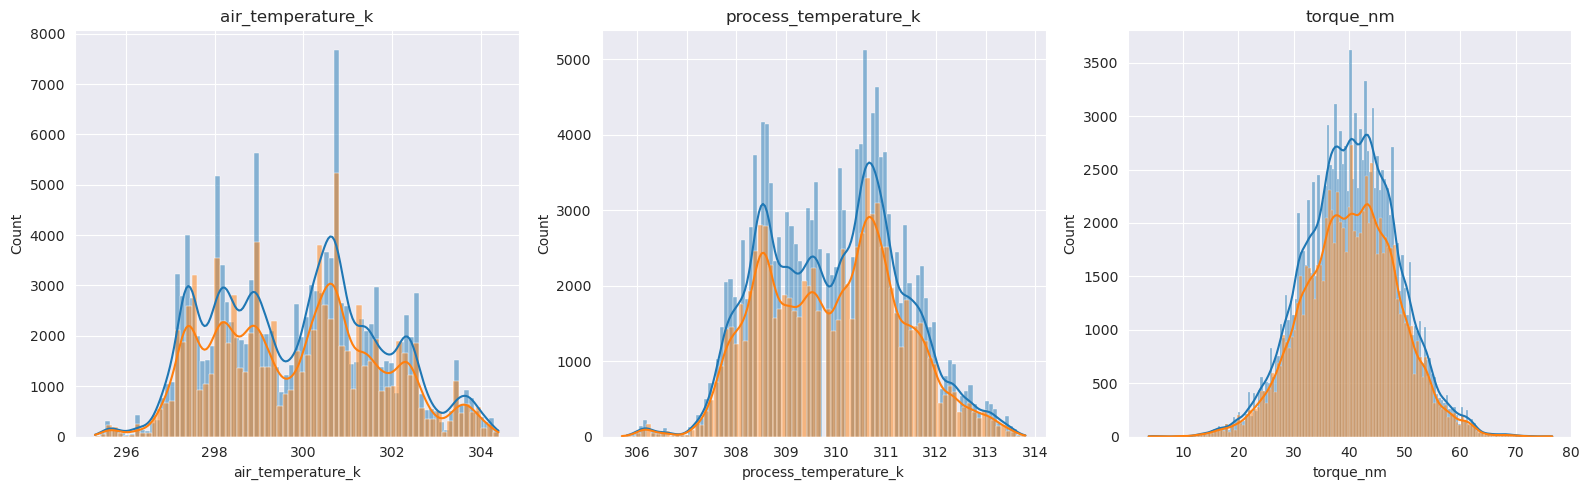

In [9]:
features = [col for col in train.columns if train[col].dtype=='float']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(16,5*rows),tight_layout=True) 
for i,col in enumerate(features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)

In [10]:
bool_cols = [col for col in test.columns if test[col].nunique() == 2]
bool_cols

['twf', 'hdf', 'pwf', 'osf', 'rnf']

In [11]:
# %%time
# cat_features = [col for col in bool_cols]
# rows = int(np.ceil(len(cat_features)/3)) 
# plt.figure(figsize=(16,5*rows),tight_layout=True) 
# for i,col in tqdm(enumerate(cat_features)): 
#   plt.subplot(rows,3,i+1) 
#   sns.histplot(train[col]) 
#   sns.histplot(test[col])
#   plt.title(col)

In [12]:
for col in bool_cols:
    print(f'{col}:\n{train[col].value_counts()}')
    
# should we upsample or downsample these columns?

twf:
0    135087
1       208
Name: twf, dtype: int64
hdf:
0    134594
1       701
Name: hdf, dtype: int64
pwf:
0    134975
1       320
Name: pwf, dtype: int64
osf:
0    134762
1       533
Name: osf, dtype: int64
rnf:
0    134989
1       306
Name: rnf, dtype: int64


### Downsample
* Try some different techniques.


* very imbalanced, almost all false

## Target feature

<Axes: ylabel='Frequency'>

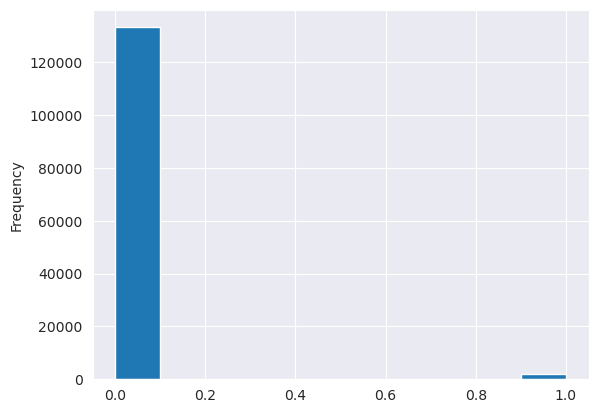

In [13]:
train.machine_failure.plot(kind='hist')

### Takeaways
* very imbalanced class, use stratified kfold

## Feature Engineering

In [14]:
train.type = train.type.apply(lambda x: 0 if x == 'L' else 1 if x == 'M' else 2)
test.type = test.type.apply(lambda x: 0 if x == 'L' else 1 if x == 'M' else 2)

In [15]:
train = train.drop('product_id',axis=1)
test = test.drop('product_id',axis=1)
train.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
0,0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,0,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,0,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,1,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [16]:
# train['sum_bool'] = train['twf'] + train['hdf'] + train['pwf'] + train['osf'] + train['rnf']
# test['sum_bool'] = test['twf'] + test['hdf'] + test['pwf'] + test['osf'] + test['rnf']

### Sum of bool cols

In [17]:
train.shape

(135295, 12)

In [18]:
train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            136419, 136420, 136421, 136422, 136423, 136424, 136425, 136426,
            136427, 136428],
           dtype='int64', length=135295)

In [19]:
train.tail()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
136424,1,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,2,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,0,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,0,301.7,310.9,1447,46.3,42,0,0,0,0,0,0
136428,0,296.9,308.1,1557,39.3,229,0,0,0,0,0,0


## Scaling/Transforming

In [20]:
float_features = [col for col in train.columns if train[col].dtype=='float']
features = [col for col in test.columns]

In [21]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# std_scaler = StandardScaler()
# mm_scaler = MinMaxScaler()
# rob_scaler = RobustScaler()

# # swap out which scaler you want here (some people scale inside of CV)
# train[float_features] = pd.DataFrame(rob_scaler.fit_transform(train[float_features]), columns = float_features)
# test[float_features] = pd.DataFrame(rob_scaler.transform(test[float_features]), columns = float_features)

In [22]:
sfeatures = ['air_temperature_k',
 'process_temperature_k',
 'rotational_speed_rpm',
 'torque_nm',
 'tool_wear_min']
sfeatures

['air_temperature_k',
 'process_temperature_k',
 'rotational_speed_rpm',
 'torque_nm',
 'tool_wear_min']

In [23]:
# from sklearn.preprocessing import QuantileTransformer

# qt = QuantileTransformer(output_distribution='normal')
# train[sfeatures] = pd.DataFrame(qt.fit_transform(train[sfeatures]),columns=sfeatures)
# test[sfeatures] = pd.DataFrame(qt.transform(test[sfeatures]),columns=sfeatures)


In [24]:
train = train.dropna()
y = train.machine_failure
train = train.drop('machine_failure',axis=1)

In [25]:
weights_ratio = 1.0/y.mean()
weights_ratio

63.548614372945046

## Model

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

seed = 12
folds = 20

In [27]:
# split data for baseline - example
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train[features], y, train_size=0.8, test_size=0.2,
                                                      random_state=12)
x_test = test[features]

In [28]:
# if continuous, change predict_proba to predict
def run_cv_and_predict(train, test, features, model, seed):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)
    # Use KFold if target is continuous
    #skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = roc_auc_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        #print(f'Log Loss Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])[:,1]
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = roc_auc_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'ROC AUC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

### Model 1: Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state = seed,
                                   solver = 'liblinear',
                                   penalty='l2',
                                   multi_class = 'auto', 
                                   max_iter=100)

preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,seed)


# model_lrg.fit(x_train, y_train)
# preds_lrg = model_lrg.predict_proba(x_valid)[:,1]  # or just predict
# score_lrg = roc_auc_score(y_valid,preds_lrg)
# print(f'ROC AUC Score, i = {0}: {score_lrg}')

# test_preds = model_lrg.predict_proba(x_test)[:,1]
# default: .88269
# initial params, .92034, lb = .94621
# 10 fold stratified kfold: .93581, lb = .94726
# no bool, only sum: ROC AUC score: 0.93624, Stdev: 0.01002, OOF score: 0.93627 (better)


ROC AUC score: 0.93543, Stdev: 0.01993, OOF score: 0.93550


### Model 2: KNN

In [30]:
# from sklearn.neighbors import KNeighborsClassifier

# # need to add (probability=True) if want to use proba
# model_knn = KNeighborsClassifier()#n_neighbors=9, leaf_size=20)

# preds_knn,scores_knn,oof_score_knn,oof_knn = run_cv_and_predict(train,test,features,model_knn,seed)

# initial cv = .72754

### Model 3: Random Forest

In [31]:
# %%time
# from sklearn.ensemble import RandomForestClassifier

# model_rf = RandomForestClassifier(class_weight='balanced')

# preds_rf,scores_rf,oof_score_rf,oof_rf = run_cv_and_predict(train,test,features,model_rf,seed)


# rf default initial, cv = .94384, lb = .95816
# adding 'class_weight = balanced', cv = .95366, lb = .95997

## Model 4: SVM

* Super slow, aborted twice

In [32]:
# %%time
# from sklearn.svm import SVC

# model_svm = SVC(class_weight='balanced',probability=True)

# preds_svm,scores_svm,oof_score_svm,oof_svm = run_cv_and_predict(train,test,features,model_svm,seed)


## Model 5: Catboost

In [33]:
weights_ratio

63.548614372945046

In [34]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(verbose=False,random_state=seed,scale_pos_weight=weights_ratio) # ,task_type='GPU')

preds_cat,scores_cat,oof_score_cat,oof_cat = run_cv_and_predict(train,test,features,model_cat,seed)

# default: ROC AUC score: 0.96057, Stdev: 0.00954, OOF score: 0.96037, lb = .96389
# same, but with scale_pos_weights, cv = .95549, lb = .96585
# same, but 1/scale_pos_weights, cv = .95913, lb = .95928

#.95549 w/o sum_bool, .95098 with :<
# drop bools except for sum, scale_pos: ROC AUC score: 0.95362, Stdev: 0.00958, OOF score: 0.95347, lb = 
# no imbalance, ROC AUC score: 0.96086, Stdev: 0.00897, OOF score: 0.96063


ROC AUC score: 0.95561, Stdev: 0.01893, OOF score: 0.95543


## Model 6 XGB

* Need to remove [] from feat names

In [35]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(random_state=seed)# max_depth= 8, n_estimators= 125, random_state= 0,  learning_rate= 0.03)

preds_xgb,scores_xgb,oof_score_xgb,oof_xgb = run_cv_and_predict(train,test,features,model_xgb,seed)

# default not balanced, ROC AUC score: 0.96159, Stdev: 0.00810, OOF score: 0.96136, lb = .96648
# defautl balanced, ROC AUC score: 0.95471, Stdev: 0.00729, OOF score: 0.95464, 
# add sum_bool,  .95369 without :<
# not balanced, with sum_bool: .96032 :<
# drop bools except for sum, no scale_pos, ROC AUC score: 0.96094, Stdev: 0.00717, OOF score: 0.96077


# back to default, not balanced for blend, .96159, lb = .96648 (best so far)

# 20 folds: .96178

ROC AUC score: 0.96178, Stdev: 0.01879, OOF score: 0.96167


## Model 7: LightGBM


In [36]:
from lightgbm import LGBMClassifier

model_lgbm = LGBMClassifier(random_state=seed)#,is_unbalance=True)

preds_lgbm,scores_lgbm,oof_score_lgbm,oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,seed)

# default, not balanced, ROC AUC score: 0.96361, Stdev: 0.00706, OOF score: 0.96326, lb = .96468
# default, is_unbalance = true,  ROC AUC score: 0.95734, Stdev: 0.01188, OOF score: 0.95699, lb = .96235
# add sum_bool: .95400 :<
# drop bools except for sum, imabalance,  ROC AUC score: 0.95562, Stdev: 0.00933, OOF score: 0.95528
# no scale_pos: ROC AUC score: 0.96262, Stdev: 0.00759, OOF score: 0.96188
# back to line 1 for ensemble
# 20 folds: .96101

ROC AUC score: 0.96101, Stdev: 0.01658, OOF score: 0.96053


## Model 8: Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

#transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))
# pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
# pipeline.fit(train_code, target)

model_gnb = GaussianNB()
preds_gnb,scores_gnb,oof_score_gnb,oof_gnb = run_cv_and_predict(train,test,features,model_gnb,seed)

ROC AUC score: 0.94443, Stdev: 0.01823, OOF score: 0.94459


In [38]:
# from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay
# from tabpfn import TabPFNClassifier

# model_tab = TabPFNClassifier()#device='cuda', N_ensemble_configurations=4)

# preds0_tab,preds1_tab, scores_tab,oof_score_tab,oof_tab = run_cv_and_predict(train,test,features,model_tab,seed)

## Three model blend

In [39]:
# import random

# model1 = oof_lr
# preds_1 = preds_lr

# model2 = oof_rf
# preds_2 = preds_rf

# model3 = oof_lgbm
# preds_3 = preds_lgbm

# m = []
# for i in range(100):
#     # Generate 3 random numbers
#     a,b,c = random.random(),random.random(),random.random()
#     # Scale the numbers so that they sum to 1
#     total = a + b + c
#     a /= total
#     b /= total
#     c /= total
    
#     tm_ens = a*model1 + b*model2 + c*model3
#     tm_score = roc_auc_score(y,tm_ens)
#     m.append([a,b,c,tm_score])
    
# three_model = pd.DataFrame(m,columns=['a','b','c','score'])
# three_model.head()

# #max score
# max_row = three_model[three_model.score == three_model.score.max()]
# print(max_row)
# ratio1 = max_row.a.values[0]
# ratio2 = max_row.b.values[0]
# ratio3 = max_row.c.values[0]

# preds_ens = ratio1*preds_1.mean(axis=1) + ratio2*preds_2.mean(axis=1) + ratio3*preds_3.mean(axis=1)

#cat +  xgb + lgbm, no scale_pos: oof=.965154, lb=.96565
#cat +  xgb + lgbm, cat scale_pos, oof=.964622, lb = .96613 (just lower than cat alone )
# rf + xgb + lgbm, 
# lr + xgb + lgbm, oof=.964566, lb = .96526


## Five model

In [40]:
import random 

model1 = oof_xgb
preds_1 = preds_xgb

model2 = oof_xgb
preds_2 = preds_xgb

model3 = oof_xgb
preds_3 = preds_xgb

model4 = oof_lgbm
preds_4 = preds_lgbm

model5 = oof_cat
preds_5 = preds_cat

m = []
for i in range(100):
    # Generate 3 random numbers
    a,b,c,d,e = random.random(),random.random(),random.random(),random.random(),random.random()
    # Scale the numbers so that they sum to 1
    total = a + b + c + d + e
    a /= total
    b /= total
    c /= total
    d /= total
    e /= total
    
    tm_ens = a*model1 + b*model2 + c*model3 + d*model4 + e*model5
    tm_score = roc_auc_score(y,tm_ens)
    m.append([a,b,c,d,e,tm_score])
    
five_model = pd.DataFrame(m,columns=['a','b','c','d','e','score'])
five_model.head()

#max score
max_row = five_model[five_model.score == five_model.score.max()]
print(max_row)
ratio1 = max_row.a.values[0]
ratio2 = max_row.b.values[0]
ratio3 = max_row.c.values[0]
ratio4 = max_row.d.values[0]
ratio5 = max_row.e.values[0]

preds_ens = ratio1*preds_1.mean(axis=1) + ratio2*preds_2.mean(axis=1) + ratio3*preds_3.mean(axis=1) + ratio4*preds_4.mean(axis=1) + ratio5*preds_5.mean(axis=1)


           a         b         c         d         e    score
68  0.236044  0.276984  0.165207  0.313589  0.008175  0.96333


## Submission

In [41]:
#final_preds = preds_lgbm.mean(axis=1)
final_preds = preds_ens
ss['Machine failure'] = final_preds
ss.head()


,id,Machine failure
0,136429,0.000880
1,136430,0.007107
2,136431,0.000278
3,136432,0.000782
4,136433,0.001918


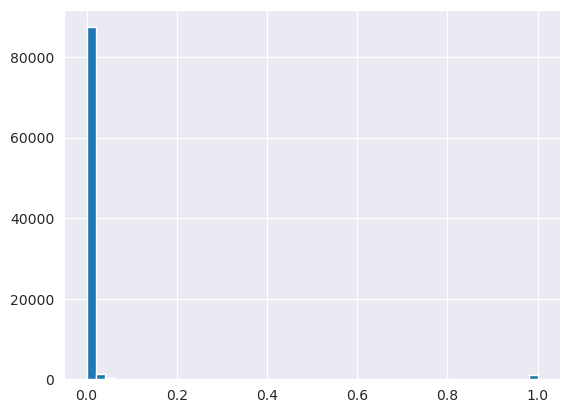

In [42]:
ss.to_csv('submission.csv',index=False)
plt.hist(final_preds,bins=50);

In [43]:
#ss['Machine failure'].value_counts()